## Seattle Airbnb Open Data Analysis (Part 1)

This report is split into multiple notebooks as follows.
<br>
###### Part 1 (This notebook)
 1 . Business Understanding<br>
 2 . Data Understanding
###### Part 2 ([link](./Seattle Airbnb Open Data - Part 2.ipynb))
 3 . Data Preparation<br>
###### Part 3 ([link](./Seattle Airbnb Open Data - Part 3.ipynb))
 4 . Data Modeling<br>
 5 . Results Evaluation<br>
###### Blog Post 
 6 . Deployment (to be linked from README.md)<br>

### 1. Business Understanding
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA. [(source)](https://www.kaggle.com/airbnb/seattle/home)

The following Airbnb activity is included in this Seattle [dataset](https://www.kaggle.com/airbnb/seattle/data): 
* Listings, including full descriptions and average review score 
* Reviews, including unique id for each reviewer and detailed comments 
* Calendar, including listing id and the price and availability for that day

For more ideas, visualizations of all Seattle datasets can be found [here](http://insideairbnb.com/seattle/).

Questions we try to analyze in this report are as follows:
###### Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?
###### Q2: Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
###### Q3: How well can we predict a price of Seattle Airbnb listings? What aspects correlate well to price?

### 2. Data Understanding
Three data files were downloaded to local environment.<br>
To begin with, let's import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 2-1. Calendar Data Understanding
First checking calendar data.<br>
We read it into pandas DataFrame and get some basic information.

In [2]:
calendar_df = pd.read_csv('./calendar.csv')
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
calendar_df.tail()

,listing_id,date,available,price
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN
1393569,10208623,2017-01-02,f,NaN


'date' seems to range from 2016-01-04 to 2017-01-02 for each 'listing_id'.<br>
To confirm it, grouping the data with 'listing_id'

In [4]:
calendar_df.groupby('listing_id').count().head()

,date,available,price
listing_id,,,
3335,365,365,309
4291,365,365,365
5682,365,365,309
6606,365,365,365
7369,365,365,53


So year 2016 calendar is available for each listing.<br>
We can get monthly price trend later.

In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


* 'date' is in string type and will need conversion to more convenient format later.
* From numbers of each colum, we can see taht only 'price' column has NaN.<br>
* Is there any rows with t in 'available' and Nan in 'price? Let's check.

In [6]:
((calendar_df['available'] == 't') & (calendar_df['price'].isnull())).sum()

0

Seems not. So 'available' means that 'price' is available.

###### Calendar Data Understanging Summary:
* Price calendar is available for 365 days of 2016 for each listing.
* 'date' column is in string type and we might need format conversion later.
* Only 'price' column has NaN for those dates each listing is not available. But we can still get monthly mean values for price.

#### 2-2. Reviews Data Understanding
Next, checking 'reviews' data.

In [7]:
reviews_df = pd.read_csv('./reviews.csv')
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [8]:
reviews_df.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."
84848,9727246,56429621,2015-12-13,30860360,Stephanie,"Breanne was a great host. Check in was easy, s..."


Let's check what kind of period is this data covering?

In [9]:
reviews_df['date'].nunique() / 365

5.287671232876712

It seems that this data is covering all reviews over 5 years period.<br>
We can get review count timeline trend as well as liting count trend later.

In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


* 'date' column will need conversion later.
* Only 'comments' column has a few NaN. But probably we don't need it this time.

###### Reviews Data Understanding Summary:
* This data is collecting reviews over five years period. We can get review count trend in timeline as well as reviewed listing count trend.
* 'date' column is in string type and we might need format conversion later.
* Only 'comments' column has a few NaN.

#### 2-3. Listings Data Understanding
Let's check listings data next.

In [11]:
listings_df = pd.read_csv('./listings.csv')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Such a long column (92) and cannot show all at a time. We have to split it and check. <br>
But before that, we can take a look at whole NaN distribution.

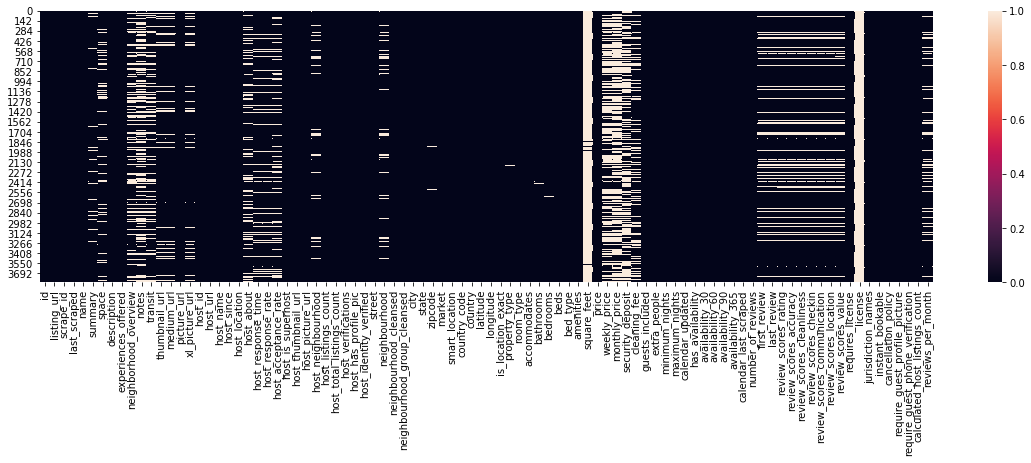

In [18]:
plt.figure(figsize=(20, 5))
sns.heatmap(listings_df.isnull(), xticklabels=listings_df.columns)
plt.show()

* There are two columns, 'square_feet' and 'license', which have almost all filled with NaN. We should drop them later.
* On right side, some colums seem to have same distribution pattern. Seems they are related to reviews. We will check them later.

In [13]:
# Collecting columns to drop for later.
dropping_cols = ['square_feet', 'license']

Now we will check all columns, separating data to each 20 columns.

In [14]:
# first 20 columns (0 - 19)
listings_df.iloc[:, :20].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,https://a1.muscache.com/ac/pictures/6120468/b0...,NaN,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29


* There are id colums, url columns, free text columns, and date columns.
* 'last_scraped' column seem all same date. We will confirm it soon.
* Date columns, 'last_scraped' and 'host_since' will probably need to format conversion later.
* What is 'experienced_offered' column type and values. We will confirm it soon.
* Free text and URL columns are difficult to quantify, but maybe we could make size information or binary flags whether information is available later.

In [15]:
# Is 'last_scraped' value all the same? -> Yes.
listings_df['last_scraped'].value_counts()

2016-01-04    3818
Name: last_scraped, dtype: int64

We could drop it, but together with other date columns, we can calculate some durations. So keep it as date columns for now.<br>
And we can say that listings data is a spapshot of listings information as of Jan. 2016.

In [16]:
# What is 'experienced_offered' type and values? -> int type and all the same value. THus, we can drop it later.
listings_df['experiences_offered'].value_counts()

none    3818
Name: experiences_offered, dtype: int64

In [17]:
# Update or collect eacy type of column name list.

# Update dropping list
dropping_cols += ['experiences_offered']

# Collecting ID columns
id_cols = ['id', 'scrape_id', 'host_id']

# Collecting URL columns
url_cols = ['listing_url', 'thumbnail_url', 'medium_url',
            'picture_url', 'xl_picture_url', 'host_url']

# Collecting free text columns
text_cols = ['name', 'summary', 'space', 'description',
             'neighborhood_overview', 'notes', 'transit', 'host_name']
# 'host_name' size cannot be a model training feature by common sense. But binary flag might make sense. So keep it for now.

# Collecting date columns
date_cols = ['last_scraped', 'host_since']

In [18]:
# next 20 columns (20 - 39)
listings_df.iloc[:, 20:40].head()

,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state
0,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA
1,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA
2,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA
3,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,https://a2.muscache.com/ac/users/9851441/profi...,https://a2.muscache.com/ac/users/9851441/profi...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA
4,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA


* There are some host location and listing location columns. Some of them must be all the same. We will collect them separately from text columns for further analysis.
* There are some categorical columns, such as 'host_responce_time'.
* There are some numeric columns, such as 'host_listings_count'.
* There are two columns with % mark. They will be changed to numeric.
* 'host_verifications' is flag encoded text. We need to decode it into elements later.

In [19]:
# Collecting location columns
location_cols = ['host_location', 'host_neighbourhood', 'street', 'neighbourhood', 'neighbourhood_cleansed',
                 'neighbourhood_group_cleansed', 'city', 'state']

# Updating text columns
text_cols += ['host_about']

# Collecting categorical columns
cat_cols = ['host_response_time', 'host_is_superhost',
            'host_has_profile_pic', 'host_identity_verified']

# Collecting numeric columns
num_cols = ['host_listings_count', 'host_total_listings_count']

# Collecting percent columns
percent_cols = ['host_response_rate', 'host_acceptance_rate']

# Updating URl columns
url_cols += ['host_thumbnail_url', 'host_picture_url']

# Collecting encoded columns
encoded_cols = ['host_verifications']

In [20]:
# next 20 columns (40 - 59)
listings_df.iloc[:, 40:60].head()

,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price
0,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN
1,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00"
2,98119,Seattle,"Seattle, WA",US,United States,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$975.00,NaN,NaN
3,98119,Seattle,"Seattle, WA",US,United States,47.638473,-122.369279,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,$100.00,$650.00,"$2,300.00"
4,98119,Seattle,"Seattle, WA",US,United States,47.632918,-122.372471,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,$450.00,NaN,NaN


* We can use 'latitude' and 'longitude' as they are. So they are added in numeric columns list.
* 'amenities' is a encoded column.
* There are some currency columns that we have to remove '&' marks and ',' marks in order to make it numeric.
* We will use 'price' column as a target of prediction model.
* 'square_feet' has been added into drop list earlier because almost all NaN.

In [21]:
# Updating numeric columns
num_cols += ['latitude', 'longitude',
             'accommodates', 'bathrooms', 'bedrooms', 'beds']

# Updating encoded columns
encoded_cols += ['amenities']

# Collecting currency columns
currency_cols = ['price', 'weekly_price', 'monthly_price']

# Updating location columns
location_cols += ['zipcode', 'market',
                  'smart_location', 'country_code', 'country']

# Updating categorical columns
cat_cols += ['is_location_exact', 'property_type',
             'room_type', 'bed_type']

In [22]:
# next 20 columns (60 - 79)
listings_df.iloc[:, 60:80].head()

,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin
0,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0
1,$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0
2,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220,2016-01-04,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0
3,NaN,NaN,1,$0.00,1,1125,6 months ago,t,0,0,0,143,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN
4,$700.00,$125.00,6,$15.00,1,1125,7 weeks ago,t,30,60,90,365,2016-01-04,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0


* 'calendar_updated' seems to need special conversion. Adding it into encoded columns for now.

In [23]:
# Updating encoded columns
encoded_cols += ['calendar_updated']

# Updating currency columns
currency_cols += ['security_deposit', 'cleaning_fee', 'extra_people']

# Updating numeric columns
num_cols += ['guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
             'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
             'review_scores_checkin']

# Updating categorical columns
cat_cols += ['has_availability']

# Updating date columns
date_cols += ['calendar_last_scraped', 'first_review', 'last_review']

In [24]:
# last 12 columns(80 - 91)
listings_df.iloc[:, 80:].head()

,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,10.0,9.0,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


* No new type of column. We just update each list.
* 'license' column has been added to dropping list earlier (almost all NaN).

In [25]:
# Updating numeric columns
num_cols += ['review_scores_communication', 'review_scores_location', 'review_scores_value',
             'calculated_host_listings_count', 'reviews_per_month']

# Updating categorical columns
cat_cols += ['requires_license', 'instant_bookable', 'cancellation_policy',
             'require_guest_profile_picture', 'require_guest_phone_verification']

# Updating location columns
location_cols += ['jurisdiction_names']

In [26]:
# Just checking all colunms are included in some lists. -> OK.
all_cols = [
    dropping_cols,
    id_cols,
    url_cols,
    text_cols,
    date_cols,
    location_cols,
    cat_cols,
    num_cols,
    percent_cols,
    encoded_cols,
    currency_cols
]

set(np.concatenate(all_cols)) == set(listings_df.columns.values)

True

In [27]:
# Change it to dictionary form and save it as a pickle file for reuse.
listings_cols_dict = {
    'dropping_cols': dropping_cols,
    'id_cols': id_cols,
    'url_cols': url_cols,
    'text_cols': text_cols,
    'date_cols': date_cols,
    'location_cols': location_cols,
    'cat_cols': cat_cols,
    'num_cols': num_cols,
    'percent_cols': percent_cols,
    'encoded_cols': encoded_cols,
    'currency_cols': currency_cols
}

with open('listings_cols_dict.pickle', 'wb') as f:
    pickle.dump(listings_cols_dict, f)

###### Listing Data Understanding Summary:
* Listings data is a spapshot of listings information as of Jan. 2016.
* Listing data columns have been categorized into following lists:
     * dropping_cols
     * id_cols
     * url_cols
     * text_cols
     * date_cols
     * location_cols
     * cat_cols
     * num_cols
     * percent_cols
     * encoded_cols
     * currency_cols
* Some 'reviews' related columns have same NaN distribution pattern.
* 'last_scraped' column have all same date. But together with other date columns, we can calculate some durations.
* Date columns will need format conversion later.
* Free text and URL columns could be converted into size information or binary flags whether information is available.
* There are some host location and listing location columns, which we will have to check redundancies and duplicates.
* There are some columns with % mark. They will have to be changed to numeric.
* Encoded columns with special encoding: 'host_verifications', 'amenities', and 'calendar_updated'
* There are some currency columns that we have to remove '$' and ',' marks.
* We will use 'price' column as a target of prediction model.
